In [116]:
#Материалы:
#https://www.youtube.com/watch?v=gXBs4_3aKrs&feature=youtu.be
#https://habr.com/ru/company/hh/blog/427477/

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('qqplot')
from datetime import datetime, date
%matplotlib inline

In [174]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [175]:
#Признаки рассчитываются для пары: П+стаж его работы в SkyEng в месяцах.
#Считается, что П работал в месяце A, если у него были успешные уроки в этом месяце.

#Рассматриваемые признаки (приведены к нормальному виду в файле):

#1. Пол - бинарный признак (1 - женщина)
#2. Регион (RU/не RU) - бинарный признак
#3.Город (Чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между очень крупными и мелкими городами)
#3. Возраст (разбит на группы: (18-23;24-29;30+) с присвоением номера (0,1,2). Возраст расситывается на момент рассматриваемого месяца
#Категория (A, B, C, Critical --> 0,1,2,3) - данные из KPI
#SLA начала 1у (Начинает ли П занятия вовремя в месяце) - доля уроков, для которых П завел комнату вовремя (минимум за 1 мин)
#SLA подтверждения У в TT (накопительно) - Вовремя ли П подтверждает У (в течение 12 часов)
#Процент переподбора (накопительно) - доля замен учителя



In [176]:
df = pd.read_excel(r'C:\Users\79035\clustering_of_teachers.xlsx')
df = df[df['Есть незаполненные поля'] == 'Нет']

In [177]:
df_for_clust = df[['gender_normal','age_normal', 'country_normal', 'city_normal', 'category_normal','sla_начала_1у_normal',
                  'Процент переподбора_normal', 'sla_подтверждения_У_normal', 'open_hours_normal', 'praim_time_hours_normal',
                  'count_uniq_students_normal', 'count_of_lessons_normal', 'discipline_normal', 'lost_students']]

#Копирую, иначе ругается при дальнейшей работе с датафрейм
df_for_clust = df_for_clust.copy()


In [178]:
df_for_clust = df_for_clust.apply(pd.to_numeric) # приводим к числовому типу данных, так как были текстовые значения
df_for_clust.dtypes

gender_normal                   int64
age_normal                    float64
country_normal                  int64
city_normal                   float64
category_normal               float64
sla_начала_1у_normal          float64
Процент переподбора_normal    float64
sla_подтверждения_У_normal    float64
open_hours_normal             float64
praim_time_hours_normal       float64
count_uniq_students_normal    float64
count_of_lessons_normal       float64
discipline_normal             float64
lost_students                 float64
dtype: object

In [179]:
df_for_clust.head()

,gender_normal,age_normal,country_normal,city_normal,category_normal,sla_начала_1у_normal,Процент переподбора_normal,sla_подтверждения_У_normal,open_hours_normal,praim_time_hours_normal,count_uniq_students_normal,count_of_lessons_normal,discipline_normal,lost_students
69,1,0.5,1,0.685608,0.666667,0.0,0.190476,0.971429,0.050314,0.011765,0.0,0.000000,1.0000,0.0
70,1,0.5,1,0.824471,1.000000,1.0,0.000000,0.909091,0.125786,0.117647,0.0,0.023392,0.8125,0.0
71,0,0.5,1,0.555547,1.000000,0.5,0.200000,0.928571,0.050314,0.035294,0.0,0.005848,1.0000,0.0
72,1,0.5,1,0.685608,0.666667,1.0,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.0000,0.0
73,1,0.5,1,0.685608,0.666667,0.0,0.125000,1.000000,0.044025,0.023529,0.0,0.005848,1.0000,0.0


In [180]:
#Применим алгоритм иерархической кластеризации и построим дендрограмму.
#Вычисления производятся функцией linkage. Аргументы функции: 
#таблица данных
#метод вычисления расстояний между кластерами(ward, single ,complete, average)
#метод вычисления расстояний между объектами (euclidean(default), citiblock (Манхетен), hamming, cosine)

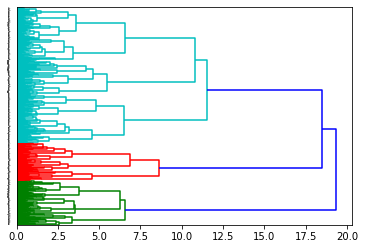

In [181]:
link = linkage(df_for_clust, 'ward', 'euclidean')
dn = dendrogram(link, orientation = "right", leaf_font_size = 0)

In [182]:
#Добавим к данным колонку cluster.
#Для этого используем функцию fcluster.
#Аргументы:
#linkage
#пороговое значение для расстояния между кластерами либо кол-во кластеров в зависимости от criterion
#maxclust для разбиения по заданному числу кластеров)

In [183]:
df_for_clust['cluster'] = fcluster(link, 3, criterion = 'maxclust')

In [184]:
df_for_clust.head()

,gender_normal,age_normal,country_normal,city_normal,category_normal,sla_начала_1у_normal,Процент переподбора_normal,sla_подтверждения_У_normal,open_hours_normal,praim_time_hours_normal,count_uniq_students_normal,count_of_lessons_normal,discipline_normal,lost_students,cluster
69,1,0.5,1,0.685608,0.666667,0.0,0.190476,0.971429,0.050314,0.011765,0.0,0.000000,1.0000,0.0,3
70,1,0.5,1,0.824471,1.000000,1.0,0.000000,0.909091,0.125786,0.117647,0.0,0.023392,0.8125,0.0,3
71,0,0.5,1,0.555547,1.000000,0.5,0.200000,0.928571,0.050314,0.035294,0.0,0.005848,1.0000,0.0,1
72,1,0.5,1,0.685608,0.666667,1.0,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.0000,0.0,3
73,1,0.5,1,0.685608,0.666667,0.0,0.125000,1.000000,0.044025,0.023529,0.0,0.005848,1.0000,0.0,3


In [185]:
df_for_clust.groupby('cluster').mean()


,gender_normal,age_normal,country_normal,city_normal,category_normal,sla_начала_1у_normal,Процент переподбора_normal,sla_подтверждения_У_normal,open_hours_normal,praim_time_hours_normal,count_uniq_students_normal,count_of_lessons_normal,discipline_normal,lost_students
cluster,,,,,,,,,,,,,,
1,0.000000,0.306167,1.0,0.645854,0.668135,0.561216,0.163477,0.918438,0.121076,0.135735,0.243707,0.217817,0.893749,0.069016
2,0.748691,0.492147,0.0,0.413002,0.455497,0.749800,0.159687,0.906995,0.102835,0.106314,0.169783,0.141300,0.928569,0.057592
3,1.000000,0.514684,1.0,0.675233,0.497797,0.663446,0.143707,0.935190,0.108137,0.103827,0.216751,0.188311,0.926152,0.055311


In [186]:
df_for_clust.groupby('cluster').size()

cluster
1    227
2    191
3    681
dtype: int64